In [46]:
import autokeras as ak
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_dir = '/Users/nikitaantipov/Documents/image_data/state-farm-distracted-driver-detection'

In [4]:
train_dir = f'{data_dir}/imgs/train'
test_dir = f'{data_dir}/imgs/test'
csv_file = f'{data_dir}/driver_imgs_list.csv'

In [5]:
def load_images_from_folder(base_folder, size=(112, 112)):
    total_images = sum([len(files) for r, d, files in os.walk(base_folder)])

    all_images = np.empty((total_images, size[0], size[1], 3), dtype=np.uint8)
    all_labels = np.empty(total_images, dtype=np.uint8)

    idx = 0
    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)
        
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                
                try:
                    img = Image.open(img_path).resize(size)
                    all_images[idx] = np.array(img)
                    all_labels[idx] = folder[-1]
                    idx += 1
                except IOError:
                    print(f"Error in reading {img_path}. Skipping.")

    return all_images, all_labels

In [6]:
base_folder = f'{data_dir}/imgs/train'
images, labels = load_images_from_folder(base_folder)

In [7]:
np.savez_compressed('train.npz', images=images, labels=labels)

In [8]:
train_npz = np.load('train.npz')
images = train_npz['images']
labels = train_npz['labels']

In [9]:
images.shape

(22424, 112, 112, 3)

In [10]:
images[0]

array([[[ 44,  52,  41],
        [ 44,  52,  41],
        [ 44,  52,  41],
        ...,
        [228, 255, 209],
        [247, 254, 232],
        [254, 254, 252]],

       [[ 44,  52,  41],
        [ 44,  52,  41],
        [ 44,  52,  41],
        ...,
        [199, 242, 190],
        [227, 252, 214],
        [244, 255, 233]],

       [[ 44,  52,  41],
        [ 45,  53,  42],
        [ 45,  53,  42],
        ...,
        [175, 225, 185],
        [187, 235, 192],
        [213, 249, 209]],

       ...,

       [[ 21,  24,  18],
        [ 16,  19,  13],
        [ 12,  15,   9],
        ...,
        [  9,   9,   5],
        [  8,   7,   5],
        [ 27,  33,  29]],

       [[ 20,  22,  14],
        [ 20,  22,  14],
        [ 19,  21,  14],
        ...,
        [ 11,   8,   5],
        [  7,   6,   4],
        [ 35,  46,  40]],

       [[ 40,  49,  36],
        [ 40,  49,  36],
        [ 39,  48,  35],
        ...,
        [ 13,   4,   5],
        [ 12,   5,   5],
        [ 33,  41,  36]]

In [11]:
labels.shape

(22424,)

In [12]:
labels[0]

7

In [13]:
X = images.astype('float32') / 255

In [14]:
X.shape

(22424, 112, 112, 3)

In [15]:
Y = to_categorical(labels, 10)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
X_train.shape, X_test.shape

((17939, 112, 112, 3), (4485, 112, 112, 3))

In [18]:
y_train.shape, y_test.shape

((17939, 10), (4485, 10))

In [22]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                968010    
                                                                 
Total params: 968906 (3.70 MB)
Trainable params: 968906 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
561/561 [==============================] - 11s 19ms/step - loss: 0.5301 - accuracy: 0.8674 - val_loss: 0.0618 - val_accuracy: 0.9851
Epoch 2/5
561/561 [==============================] - 10s 18ms/step - loss: 0.0220 - accuracy: 0.9962 - val_loss: 0.0246 - val_accuracy: 0.9944
Epoch 3/5
561/561 [==============================] - 10s 19ms/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0230 - val_accuracy: 0.9938
Epoch 4/5
561/561 [==============================] - 10s 18ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0179 - val_accuracy: 0.9962
Epoch 5/5
561/561 [==============================] - 12s 22ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0189 - val_accuracy: 0.9953


In [27]:
model.evaluate(X_test, y_test)

141/141 [==============================] - 1s 9ms/step - loss: 0.0189 - accuracy: 0.9953


[0.018888862803578377, 0.9953176975250244]

In [26]:
model.save("model.keras")

In [48]:
model_new = tf.keras.models.load_model("model.keras")

In [49]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                968010    
                                                                 
Total params: 968906 (3.70 MB)
Trainable params: 968906 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
model_new.evaluate(X_test, y_test)

141/141 [==============================] - 1s 9ms/step - loss: 0.0189 - accuracy: 0.9953


[0.018888862803578377, 0.9953176975250244]

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predictions from one-hot encoded to class numbers
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Convert true labels from one-hot encoded to class numbers
y_true_train = np.argmax(y_train, axis=1)
y_true_test = np.argmax(y_test, axis=1)

141/141 [==============================] - 1s 4ms/step


In [35]:
np.where(y_pred_test_classes != y_true_test)

(array([ 168,  239,  349,  445,  739, 1188, 1690, 1871, 1876, 2431, 2562,
        2585, 2701, 2738, 3392, 3556, 3632, 3800, 3993, 4060, 4269]),)

In [43]:
index = 239

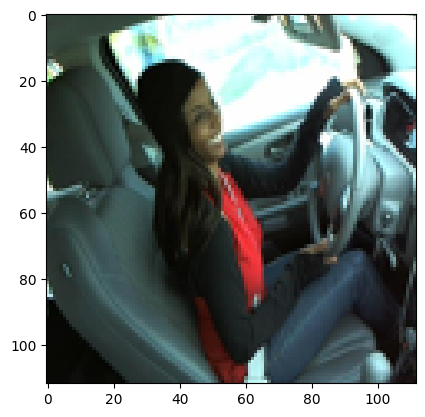

In [44]:
plt.imshow(X_test[index])

In [45]:
y_pred_test_classes[index], y_true_test[index]

(8, 9)

In [47]:
print(classification_report(y_true_train, y_pred_train_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1937
           1       1.00      1.00      1.00      1816
           2       1.00      1.00      1.00      1890
           3       1.00      1.00      1.00      1884
           4       1.00      1.00      1.00      1871
           5       1.00      1.00      1.00      1854
           6       1.00      1.00      1.00      1847
           7       1.00      1.00      1.00      1646
           8       1.00      1.00      1.00      1515
           9       1.00      1.00      1.00      1679

    accuracy                           1.00     17939
   macro avg       1.00      1.00      1.00     17939
weighted avg       1.00      1.00      1.00     17939


In [26]:
print(confusion_matrix(y_true_train, y_pred_train_classes))

[[1949    0    0    0    0    0    0    0    0    0]
 [   0 1809    0    0    0    0    0    0    0    0]
 [   0    0 1888    0    0    0    0    0    0    0]
 [   0    0    0 1854    0    0    0    0    0    0]
 [   0    0    0    0 1898    0    0    0    0    0]
 [   0    0    0    0    0 1836    0    0    0    0]
 [   0    0    0    0    0    0 1860    0    0    0]
 [   0    0    0    0    0    0    0 1605    0    0]
 [   0    0    0    0    0    0    0    0 1543    0]
 [   0    0    0    0    0    0    0    0    0 1697]]


In [27]:
print(classification_report(y_true_test, y_pred_test_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       540
           1       1.00      1.00      1.00       458
           2       1.00      1.00      1.00       429
           3       1.00      1.00      1.00       492
           4       1.00      1.00      1.00       428
           5       1.00      0.99      1.00       476
           6       1.00      1.00      1.00       465
           7       1.00      0.99      1.00       397
           8       1.00      1.00      1.00       368
           9       1.00      1.00      1.00       432

    accuracy                           1.00      4485
   macro avg       1.00      1.00      1.00      4485
weighted avg       1.00      1.00      1.00      4485


In [29]:
print(confusion_matrix(y_true_test, y_pred_test_classes))

[[539   0   0   0   1   0   0   0   0   0]
 [  0 457   0   0   0   0   0   0   0   1]
 [  0   0 429   0   0   0   0   0   0   0]
 [  0   0   0 492   0   0   0   0   0   0]
 [  0   0   0   2 426   0   0   0   0   0]
 [  3   0   0   0   0 472   0   1   0   0]
 [  0   0   0   0   0   0 465   0   0   0]
 [  0   0   2   0   0   0   0 395   0   0]
 [  0   0   0   0   0   0   0   0 367   1]
 [  0   0   0   0   0   0   0   0   1 431]]


In [11]:
n_folds = 10

kfold = KFold(n_folds, shuffle=True, random_state=42)

models = []
histories = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

In [14]:
input_node = ak.nodes.ImageInput()
output_node = ak.ImageBlock(
    block_type="vanilla",
    normalize=False,
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=100, objective='val_accuracy' 
)

In [15]:
clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Trial 100 Complete [00h 00m 23s]
val_accuracy: 0.9723522663116455

Best val_accuracy So Far: 0.9723522663116455
Total elapsed time: 00h 42m 58s
Epoch 1/10
561/561 [==============================] - 4s 4ms/step - loss: 2.0660 - accuracy: 0.2216 - val_loss: 1.3987 - val_accuracy: 0.4792
Epoch 2/10
561/561 [==============================] - 2s 4ms/step - loss: 0.8549 - accuracy: 0.7088 - val_loss: 0.5662 - val_accuracy: 0.8167
Epoch 3/10
561/561 [==============================] - 2s 4ms/step - loss: 0.4477 - accuracy: 0.8609 - val_loss: 0.3390 - val_accuracy: 0.8981
Epoch 4/10
561/561 [==============================] - 2s 4ms/step - loss: 0.2928 - accuracy: 0.9115 - val_loss: 0.2669 - val_accuracy: 0.9242
Epoch 5/10
561/561 [==============================] - 2s 4ms/step - loss: 0.2179 - accuracy: 0.9357 - val_loss: 0.2197 - val_accuracy: 0.9349
Epoch 6/10
561/561 [==============================] - 2s 4ms/step - loss: 0.1588 - accuracy: 0.9553 - val_loss: 0.1979 - val_accuracy: 0.9478
Epoc

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [16]:
model = clf.export_model()

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 cast_to_float32 (CastToFlo  (None, 112, 112, 3)       0         
 at32)                                                           
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 4)       580       
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 4)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 8)         296   

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                968010    
                                                                 
Total params: 968906 (3.70 MB)
Trainable params: 968906 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:        
        print(i, 'w', layer.get_weights()[0].shape)
        print(i, 'b', layer.get_weights()[1].shape)

0 w (3, 3, 3, 32)
0 b (32,)
3 w (96800, 10)
3 b (10,)


In [58]:
np.savez_compressed(
    'SFDDD_model.npz',
    conv_weights = model.layers[0].get_weights()[0],
    conv_biases = model.layers[0].get_weights()[1],
    dense_weights = model.layers[3].get_weights()[0],
    dense_biases = model.layers[3].get_weights()[1],
)